In [1]:
from sashimi_c import *
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
import matplotlib.pyplot as plt

# Set up
sh = halo_model()

# Define the units
unit_k = sh.h / sh.Mpc
unit_r = sh.Mpc / sh.h

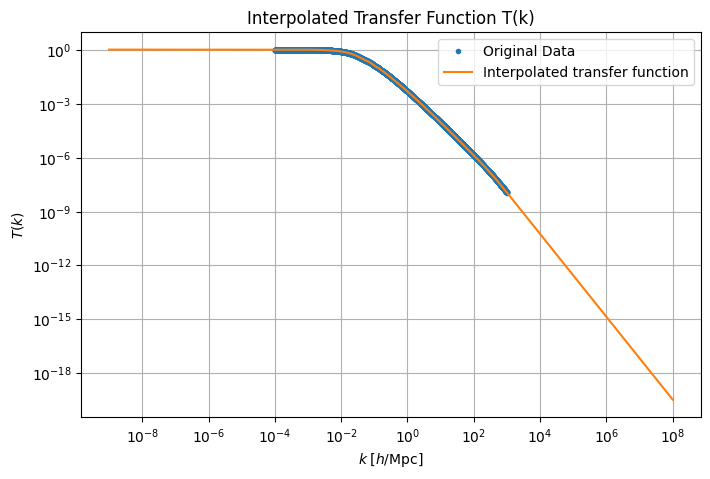

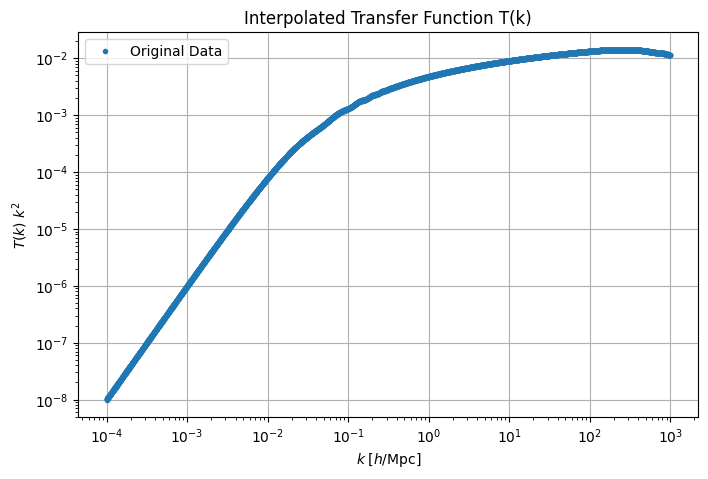

In [2]:
# Define T(k):
# Load the transfer function data from Tk_CLASS.txt as an interpolated function
# The file contains two columns: the first column is k values (h/Mpc) and the second column is the transfer function T(k)

# Notes from the file:
# CLASS transfer function for vanilla LCDM with 3 massless neutrinos
# Cosmo parameters taken from first column in Table 1 of arxiv:1807.06209
    # omega_b * (h^2) = 0.022383
    # omega_cdm * (h^2) = 0.12011
    # h = 0.6732
    # ln(10^{10} * A_s) = 3.0448
    # n_s = 0.96605

# Load the transfer function data from Tk_CLASS.txt
data = np.loadtxt('Tk_CLASS.txt')
# Extract the k values and T(k) values from the two columns
k_data = data[:,0] * unit_k   # k values (h/Mpc)
Tk_data = data[:,1]     # Transfer function T(k)

# Create the interpolation function T(k)
# transfer_function = interp1d(k_data, Tk_data, kind='linear', bounds_error=False, fill_value="extrapolate")
_transfer_function = interp1d(np.log10(k_data), np.log10(Tk_data), kind='linear', bounds_error=False, fill_value="extrapolate")
_1mtransfer_function = interp1d(np.log10(k_data), np.log10(1-Tk_data), kind='linear', bounds_error=False, fill_value="extrapolate")
# transfer_function = lambda k: 10**_transfer_function(np.log10(k))
transfer_function = lambda k: np.where(k>1e-2*unit_k, 10**_transfer_function(np.log10(k)), 1 - 10**_1mtransfer_function(np.log10(k)))

# Example: evaluate the function at some points
k_eval = np.logspace(np.log10(min(k_data))-5, np.log10(max(k_data))+5, 500)
Tk_eval = np.abs(transfer_function(k_eval))

# Optional: plot to check
plt.figure(figsize=(8, 5))
plt.loglog(k_data/unit_k, Tk_data, '.', label='Original Data')
plt.loglog(k_eval/unit_k, Tk_eval, '-', label='Interpolated transfer function')
plt.xlabel(r'$k \; [h/\mathrm{Mpc}]$')
plt.ylabel(r'$T(k)$')
# plt.xlim(1e-12,1e-5)
# plt.ylim(1-1e-2,1+1e-2)
plt.legend()
plt.grid()
plt.title('Interpolated Transfer Function T(k)')
plt.show()


# Optional: plot to check
plt.figure(figsize=(8, 5))
plt.loglog(k_data/unit_k, Tk_data * (k_data/unit_k)**2, '.', label='Original Data')
# plt.loglog(k_eval/unit_k, Tk_eval * (k_eval/unit_k)**2, '-', label='Interpolated transfer function')
plt.xlabel(r'$k \; [h/\mathrm{Mpc}]$')
plt.ylabel(r'$T(k) \; k^2$')
# plt.xlim(1e-12,1e-5)
# plt.ylim(1-1e-2,1+1e-2)
plt.legend()
plt.grid()
plt.title('Interpolated Transfer Function T(k)')
plt.show()

NOTE: the transfer function is defined for physical k.

In [3]:
def M_transfer(k,z):
    """
    Define the dimensionless function M(k,z) that connects the gravitational potential to the matter density field (in Fourier space):
        M(k,z) = 2 * c^2 * k^2 * T(k) * D(z) / (3 * OmegaM * H0^2)
    where:
        c = speed of light (in Mpc/s), from sashimi_c
        k = wavenumber (in h/Mpc, where h is the dimensionless reduced Hubble parameter)
        T(k) = transfer function (dimensionless), from Tk_CLASS.txt
        D(z) = growth factor at redshift z (dimensionless), from sashimi_c
        H0 = (present day) Hubble constant (in s^{-1}), from sashimi_c
        OmegaM = matter density parameter (dimensionless), from sashimi_c
    """
    #return 2 * (sh.c**2) * k**2 * transfer_function(k) * sh.growthD(z) / (3 * sh.OmegaM * sh.H0**2)
    return 2 * pow(sh.c,2) * pow(k,2) * transfer_function(k) * sh.growthD(z) / (3 * sh.OmegaM * pow(sh.H0,2))


def M_to_R(M,z):
    """
    Convert mass M (in Msun/h) to smoothing scale R (in Mpc/h) using the relation:
        M = (4/3) * pi * R^3 * rho_m(z)
    where rho_m(z) = OmegaM * rho_crit0 * (1+z)^3 is the mean matter density at redshift z.
    """
    R = pow(3 * M / (4 * np.pi * sh.OmegaM * sh.rhocrit0 * pow(1+z,3)), 1/3)
    return R


def Window_func(k,z,M):
    """
    Define the Fourier space window function W(k,R) for a spherical top-hat filter function in real space:
        W(k,R) = 3 * (sin(kR) - kR * cos(kR)) / (kR)^3 = 3 * j_1(kR) / (kR)
    where:
        k = wavenumber (in h/Mpc, array_like or float)
        R = smoothing scale (in Mpc/h, float)
        j_1 is spherical Bessel function of the first kind of order 1
    """
    R = M_to_R(M,z)  # Convert M to R using the mass density relation
    # Use np.where to safely handle k = 0
    return np.where(k == 0.0, 1.0, 3 * spherical_jn(1, k*R) / (k*R))
    # return np.where(k == 0.0, 1.0, 3 * (np.sin(k*R) - k*R*np.cos(k*R)) / (k*R)**3)


def M_smoothed(k,z,M):
    """
    Define the function M_smoothed(k,z,R), i.e. M(k,z) smoothed by the window function W(k,R):
        M_smoothed(k,z,R) = M(k,z) * W(k,R)
    where M(k,z) and W(k,R) are defined as above.
    This function computes the smoothed version of M(k,z) by multiplying it with the window function W(k,R).
    """
    return M_transfer(k,z) * Window_func(k,z,M)


def P_Phi(k):
    """
    Define the power spectrum P_Phi(k,z) of the gravitational potential:
        P_Phi(k) = A_s * (k/k*)^(n_s - 4)
    where:
        k = wavenumber (in h/Mpc, array_like or float)
        A_s = amplitude of the primordial power spectrum
        n_s = 0.96605 is the scalar spectral index
        k_ref = pivot scale (in h/Mpc, typically chosen to be 0.05 Mpc^{-1})
    """
    # Define the constants (from Table 1 of arxiv:1807.06209)
    A_s = np.exp(3.0448) / 1e10   # since ln(10^{10} * A_s) = 3.0448
    n_s = 0.96605
    k_ref = 0.05 * (sh.Mpc**-1)  # pivot scale in 1/Mpc
    #return A_s * (k/k_ref)**(n_s - 4) # definition from arXiv:2410.21457
    return 2 * np.pi**2 * k**-3 * A_s * (k/k_ref)**(n_s - 1) # definition from arXiv:1103.2586, this significantly improves the results


def compute_2pt_fct(M1, M2, z):
    """
    Compute the two-point correlator ⟨δ(R₁)δ(R₂)⟩ from one term in the bispectrum 
    using a two-dimensional integration via scipy.integrate.nquad.

    The expression computed is for:
         ⟨δ(R₁)δ(R₂)⟩ = 1/(2π^2) ∫₀^∞ dk k^2 * M_smoothed(k,z,R₁) * M_smoothed(k,z,R₂) * P_Phi(k)
    where:
        k = wavenumber (in h/Mpc)
        M_smoothed(k,z,R) = M(k,z) * W(k,R)
        P_Phi(k) = A_s * (k/k_ref)^(n_s - 4)
    The prefactor 1/(2π^2) comes from the integration over k in two dimensions.
    
    Parameters:
        M1, M2: masses associated with smoothing scales R1 and R2.
        z: redshift.
        
    Returns:
        The value of the two-point correlator.
    """
    prefactor = 1 / (2 * np.pi**2)
    # def integrand(k):
    #     return k**2 * M_smoothed(k, z, M1) * M_smoothed(k, z, M2) * P_Phi(k)
    # result, err = quad(integrand, 0, np.inf, epsabs=1e-6)

    def integrand(lnk):
        k = np.exp(lnk)
        return k**3 * M_smoothed(k, z, M1) * M_smoothed(k, z, M2) * P_Phi(k)
    
    # lnk_min = np.log(k_data[0])
    # lnk_max = np.log(k_data[-1]) + 10
    # result, err = quad(integrand, lnk_min, lnk_max, epsabs=1e-6, limit=200)

    # # instead, we use simpson's rule for better accuracy
    from scipy.integrate import simpson
    # simpson_k = np.log(k_data)
    simpson_k = np.linspace(np.log(k_data[0]), np.log(k_data[-1])+20, 4096)
    simpson_y = integrand(simpson_k)
    plt.plot(simpson_k, np.abs(simpson_y),label=f'z={z}, M1={M1/sh.Msun:.1e}, M2={M2/sh.Msun:.1e}',linewidth=1)
    color = plt.gca().lines[-1].get_color()
    plt.plot(simpson_k, -simpson_y,color=color,linewidth=1,linestyle='--')
    result = simpson(simpson_y, x=simpson_k)

    return prefactor * result

# Use np.vectorize to handle arrays or scalars
compute_2pt_fct = np.vectorize(compute_2pt_fct)

[620.57674967 620.35609823 620.09622873 619.790171   619.42971631
 619.00519746 618.50522988 617.91640699 617.22294187 616.40624577
 615.44443298 614.31173947 612.97784134 611.40705739 609.55741856
 607.37958654 604.81560425 601.79746464 598.2454921  594.06654821
 589.15210466 583.37628321 576.59406031 568.63999986 559.32814974
 548.45417041 535.80141241 521.1535307  504.31710411 485.15774198
 463.64987604 439.92921338 414.31585895 387.27165119 359.33594297
 331.13444089 303.2774396  276.22781642 250.33292209 225.79638744
 202.72235539 181.15165255 161.09047065 142.52277048 125.41460426
 109.72817612  95.41455801  82.41939929  70.68593981  60.15478624
  50.76391368  42.44912377  35.14436511  28.78202171  23.29307208
  18.60735874  14.65395948  11.36164936   8.65942054   6.4771064
   4.74614546   3.40045104   2.37730537   1.61832532]


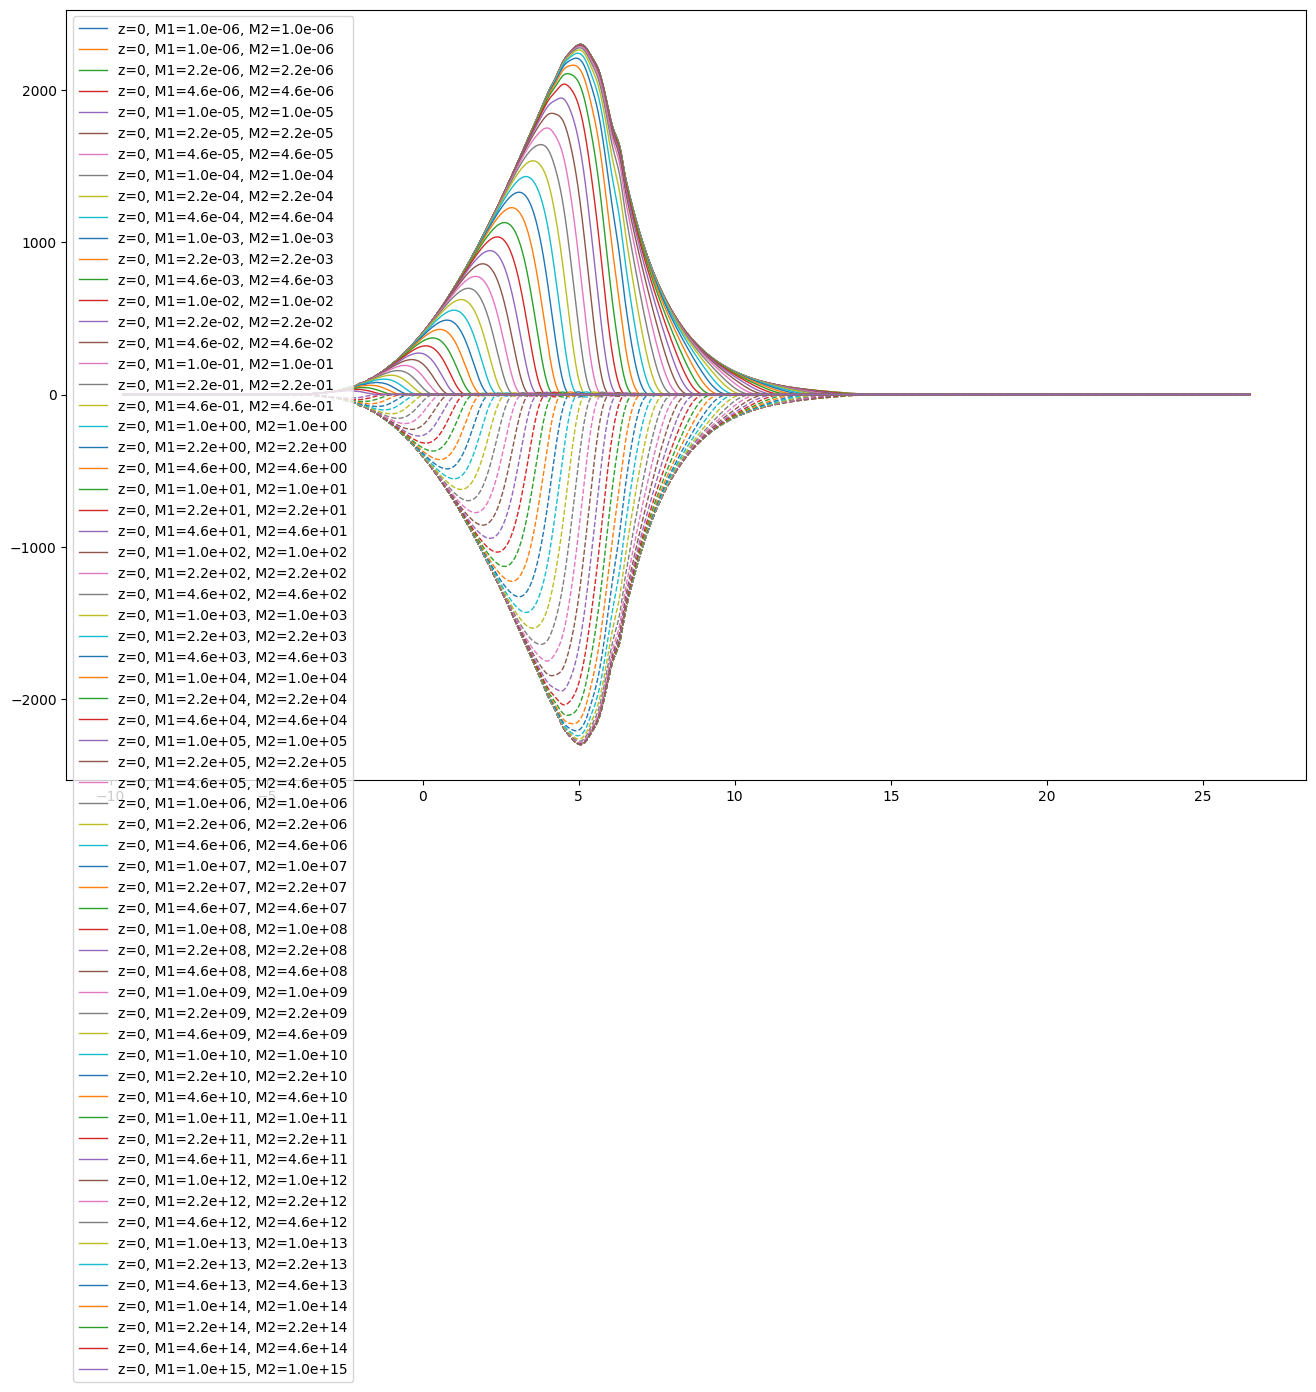

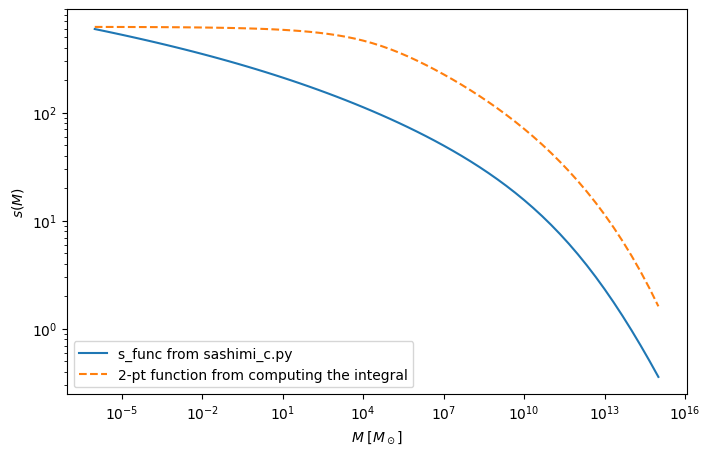

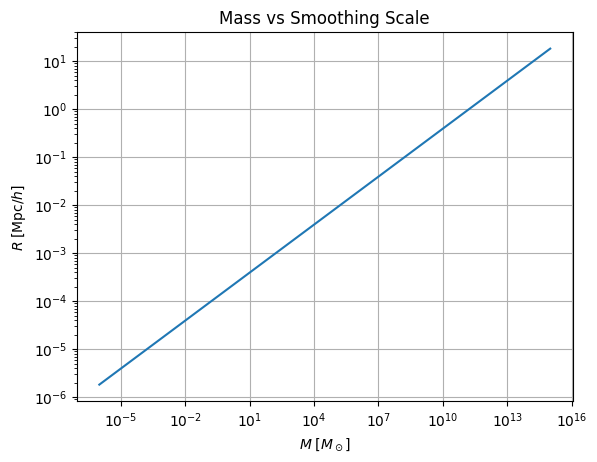

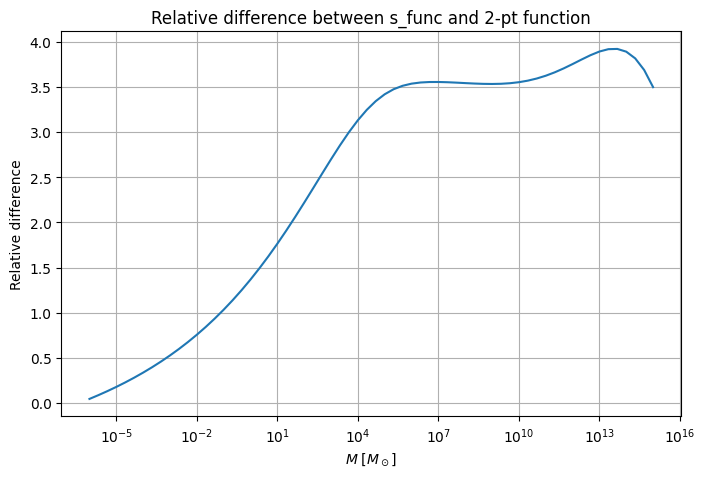

In [9]:
# compare compute_2pt_fct with s_func(M) in sashimi_c.py
M_eval = np.logspace(-6, 15, 64) * sh.Msun  # Msun
s_func_eval = sh.s_func(M_eval)
plt.figure(figsize=(16, 10))
twopt_func_eval = compute_2pt_fct(M_eval, M_eval, z=0)
print(twopt_func_eval)
# plt.yscale('log')
plt.legend(loc="upper left")
plt.show()
plt.figure(figsize=(8, 5))
plt.loglog(M_eval/sh.Msun, s_func_eval, '-', label='s_func from sashimi_c.py')
plt.loglog(M_eval/sh.Msun, twopt_func_eval, '--', label='2-pt function from computing the integral')
plt.xlabel(r'$M \; [M_\odot]$')
plt.ylabel(r'$s(M)$')
plt.legend()
plt.show()

# M vs R
plt.loglog(M_eval/sh.Msun, M_to_R(M_eval,0), '-')
plt.xlabel(r'$M \; [M_\odot]$')
plt.ylabel(r'$R \; [\mathrm{Mpc}/h]$')
plt.title('Mass vs Smoothing Scale')
plt.grid()
plt.show()
# plot relative difference
plt.figure(figsize=(8, 5))
plt.semilogx(M_eval, np.abs(s_func_eval - twopt_func_eval) / s_func_eval, '-')
plt.xlabel(r'$M \; [M_\odot]$')
plt.ylabel(r'Relative difference')
plt.title('Relative difference between s_func and 2-pt function')
plt.grid()
plt.show()

[620.57674967 620.35609823 620.09622873 619.790171   619.42971631
 619.00519746 618.50522988 617.91640699 617.22294187 616.40624577
 615.44443298 614.31173947 612.97784134 611.40705739 609.55741856
 607.37958654 604.81560425 601.79746464 598.2454921  594.06654821
 589.15210466 583.37628321 576.59406031 568.63999986 559.32814974
 548.45417041 535.80141241 521.1535307  504.31710411 485.15774198
 463.64987604 439.92921338 414.31585895 387.27165119 359.33594297
 331.13444089 303.2774396  276.22781642 250.33292209 225.79638744
 202.72235539 181.15165255 161.09047065 142.52277048 125.41460426
 109.72817612  95.41455801  82.41939929  70.68593981  60.15478624
  50.76391368  42.44912377  35.14436511  28.78202171  23.29307208
  18.60735874  14.65395948  11.36164936   8.65942054   6.4771064
   4.74614546   3.40045104   2.37730537   1.61832532]


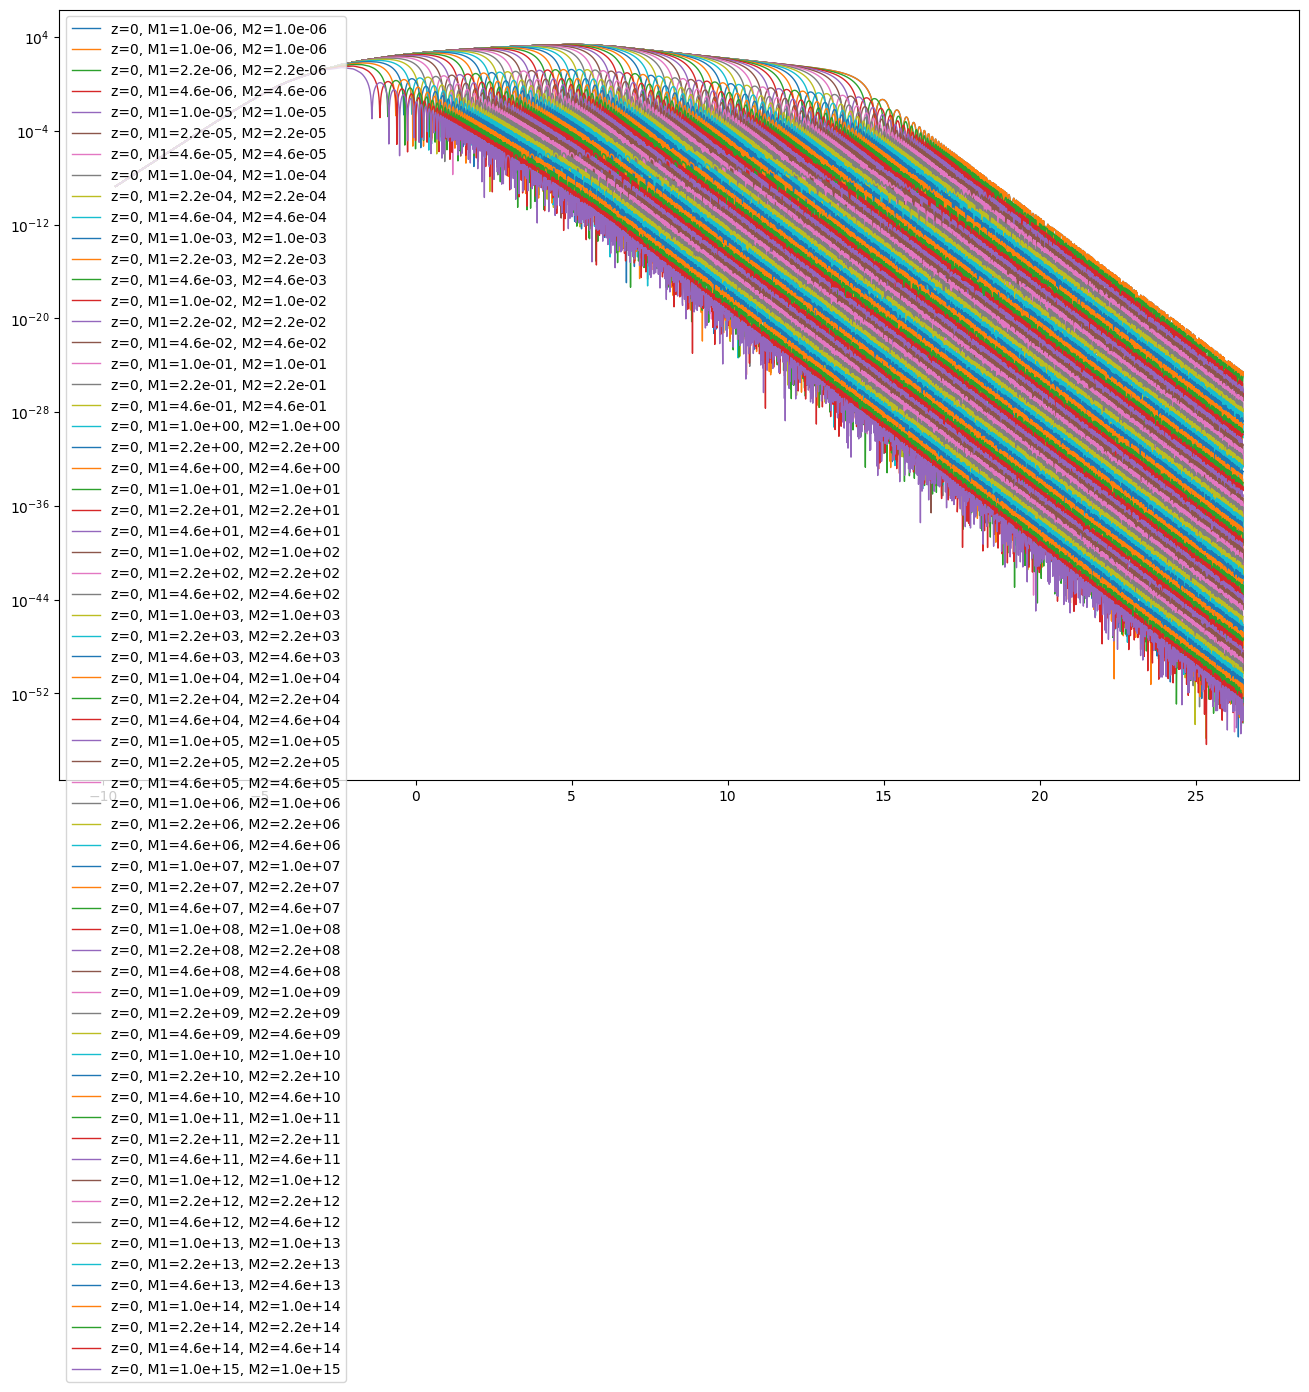

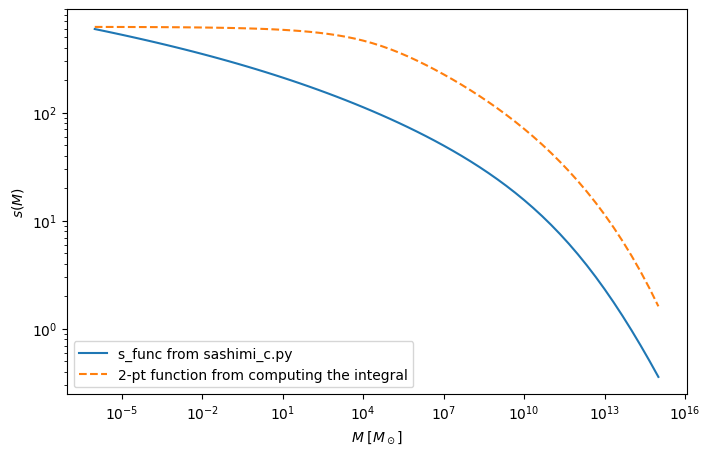

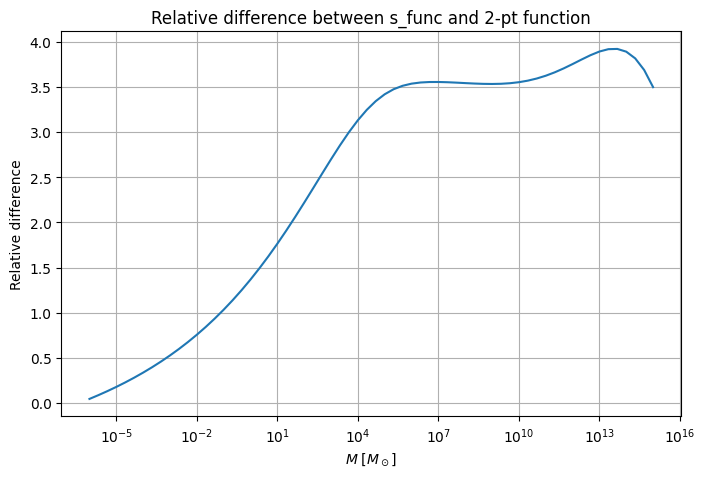

In [5]:
# compare compute_2pt_fct with s_func(M) in sashimi_c.py
M_eval = np.logspace(-6, 15, 64) * sh.Msun  # Msun
s_func_eval = sh.s_func(M_eval)
plt.figure(figsize=(16, 10))
twopt_func_eval = compute_2pt_fct(M_eval, M_eval, z=0)
print(twopt_func_eval)
plt.yscale('log')
plt.legend(loc="upper left")
plt.show()
plt.figure(figsize=(8, 5))
plt.loglog(M_eval/sh.Msun, s_func_eval, '-', label='s_func from sashimi_c.py')
plt.loglog(M_eval/sh.Msun, twopt_func_eval, '--', label='2-pt function from computing the integral')
plt.xlabel(r'$M \; [M_\odot]$')
plt.ylabel(r'$s(M)$')
plt.legend()
plt.show()

# plot relative difference
plt.figure(figsize=(8, 5))
plt.semilogx(M_eval, np.abs(s_func_eval - twopt_func_eval) / s_func_eval, '-')
plt.xlabel(r'$M \; [M_\odot]$')
plt.ylabel(r'Relative difference')
plt.title('Relative difference between s_func and 2-pt function')
plt.grid()
plt.show()

In [6]:
# Recommended: install CLASS via conda-forge to ensure compatible libstdc++
# (Already installed in this env)
# If needed as fallback: use pip
%pip install --no-cache-dir --upgrade pip
%pip install --no-cache-dir classy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--  Downloading pip-25.2-py3-none-any.whl.metadata (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart

In [7]:
from classy import Class
import matplotlib.pyplot as plt
import numpy as np
import sashimi_c

sh = sashimi_c.halo_model()
unit_k = sh.h / sh.Mpc

# read past CLASS output

k_data_raw = np.loadtxt('Tk_CLASS.txt')[:,0] * unit_k   # k values (h/Mpc)
Tk_data_raw = np.loadtxt('Tk_CLASS.txt')[:,1]     # Transfer function T

# quick smoke test
cosmo = Class()
ret = cosmo.compute(["transfer"])

tk_class = np.array([cosmo.get_transfer(k*sh.Mpc, 0) for k in k_data_raw])  # T(k) at z=0

print(tk_class)

# pk_class = np.array([cosmo.pk(ki, 0) for ki in k_data_raw])  # P(k) at z=0 in (Mpc/h)^3
# plt.loglog(k_data_raw, pk_class, label='CLASS P(k) at z=0')
# plt.loglog(k_data_raw, pk_class, 'o-', label='CLASS P(k) at z=0')
# plt.xlabel(r'$k \; [h/\mathrm{Mpc}]$')
# plt.ylabel(r'$P(k) \; [(\mathrm{Mpc}/h)^3]$')
# plt.title('Matter Power Spectrum from CLASS')
# plt.grid()
# plt.legend()
# plt.show()

print('CLASS version OK; H0 =', cosmo.pars.get('H0','unknown'))
cosmo.struct_cleanup(); cosmo.empty()

[{} {} {} ... {} {} {}]
CLASS version OK; H0 = unknown
